In [10]:
# Run in terminal or command prompt
# python3 -m spacy download en



import numpy as np
import pandas as pd
import sklearn
import re, nltk, spacy, gensim
import os
import json

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
import gensim
from gensim.models import CoherenceModel

# Plotting tools
!pip install pyLDAvis
# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

#os.chdir("/content/drive/MyDrive/Grupo MIDAS/LDA Horus")

In [11]:
#collection data is being loaded from
collection =  "lda_info"
#documents data is being loaded from
documents = [
  "_id",
  "dc:description:eng",
  "dc:title:eng"
]#read file
f = open("avois_words.txt", "r")
#this is a list of words that are not relevant to the topic
stopwords = f.read().splitlines()
f.close()

In [12]:
# Opening JSON file
f = f=open("lda_info.json","r",encoding='utf-8')

# returns JSON object as 
# a dictionary
data = f.read().splitlines()

data_full=[]
for i in data:
  data_full.append(json.loads(i))
f.close()

In [13]:
data = []
cnt = 0
for document in data_full:
    new_doc = []
    for(key, value) in document.items():
      if(key in documents):
        new_doc.append(key + ":" + str(value))
    data.append(new_doc)

In [14]:
#TOKENIZE WORDS
def tokenize_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
#Tokenizer de Stanford
data_words = list(tokenize_words(data))

print(data_words[:1])

[['numberint', 'dc', 'title', 'eng', 'systematic', 'evaluation', 'of', 'jatropha', 'curcas', 'oil', 'obtention', 'by', 'mechanical', 'and', 'solvent', 'extraction', 'dc', 'description', 'eng', 'current', 'biodiesel', 'production', 'relies', 'mostly', 'on', 'edible', 'oils', 'soybean', 'palm', 'rapeseed', 'which', 'is', 'major', 'drawback', 'for', 'the', 'process', 'as', 'raw', 'materials', 'represent', 'the', 'major', 'part', 'of', 'the', 'final', 'costs', 'of', 'the', 'biofuel', 'this', 'also', 'brings', 'out', 'concerns', 'about', 'food', 'and', 'feed', 'security', 'in', 'the', 'last', 'years', 'jatropha', 'curca', 'oil', 'has', 'obtained', 'attention', 'as', 'an', 'alternative', 'oleochemical', 'feedstock', 'because', 'it', 'is', 'perennial', 'crop', 'able', 'to', 'produce', 'up', 'to', 'gallon', 'per', 'hectare', 'year', 'of', 'non', 'edible', 'oil', 'even', 'though', 'several', 'authors', 'have', 'reported', 'process', 'conditions', 'and', 'yields', 'on', 'variety', 'of', 'extract

In [15]:
# Remove long words

def remove_long_words(words):
  for word in words:
    aux_word=[]
    for character in word:
      if len(character)>3:
          aux_word.append(character)
    yield aux_word


short_words=list(remove_long_words(data_words))

Se podría pintar el histograma de frecuencias

In [16]:
#LEMMATIZATION
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(short_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])



In [17]:
#Create a words dictionary with tokenized, clean and lemmatized elements
dictionary = gensim.corpora.Dictionary(data_lemmatized)

dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

#For each document we create an dictionary that show many words and the number of times repeated 
bow_corpus = [dictionary.doc2bow(doc) for doc in data_lemmatized]

We create a tf-idf model object using models.TfidfModel from "bow_corpus" and place it in tfidf, then apply the transformation to the entire corpus and call it corpus_tfidf. Finally, we preview the TF-IDF scores for our first document.

In [18]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.04712022481724221),
 (1, 0.03017857062411565),
 (2, 0.062394614181510016),
 (3, 0.05603770123450342),
 (4, 0.04147885214562807),
 (5, 0.05909957685270562),
 (6, 0.07549608164697481),
 (7, 0.057005479083418464),
 (8, 0.22648824494092443),
 (9, 0.058024215550057816),
 (10, 0.1257867236087987),
 (11, 0.06412151395401403),
 (12, 0.05035297592891162),
 (13, 0.05181416213577583),
 (14, 0.04712022481724221),
 (15, 0.06412151395401403),
 (16, 0.08768345080163738),
 (17, 0.06208262741732341),
 (18, 0.09669861201188158),
 (19, 0.06412151395401403),
 (20, 0.032272668393402815),
 (21, 0.04147885214562807),
 (22, 0.060833708683168175),
 (23, 0.038400707906124425),
 (24, 0.5909957685270562),
 (25, 0.07307398409491288),
 (26, 0.06485184681290412),
 (27, 0.04834930600594079),
 (28, 0.13796966223776375),
 (29, 0.11710885490769656),
 (30, 0.10070595185782324),
 (31, 0.06341774461871613),
 (32, 0.14393576336699937),
 (33, 0.06023823019508788),
 (34, 0.05557137688923049),
 (35, 0.026879139324744502

We are going to train our LDA model using gensim.models.LdaMulticore and save it to ‘lda_model’

In [19]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [20]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.011*"cluster" + 0.008*"code" + 0.007*"source" + 0.006*"datum" + 0.006*"uncertainty" + 0.006*"method" + 0.005*"network" + 0.005*"document" + 0.005*"search" + 0.005*"information"
Topic: 1 Word: 0.009*"network" + 0.007*"image" + 0.006*"production" + 0.006*"visualization" + 0.006*"strategy" + 0.006*"learn" + 0.006*"reaction" + 0.006*"price" + 0.005*"neural" + 0.005*"sequence"
Topic: 2 Word: 0.010*"network" + 0.007*"agent" + 0.005*"group" + 0.005*"service" + 0.005*"device" + 0.005*"design" + 0.005*"simulation" + 0.005*"medical" + 0.004*"control" + 0.004*"problem"
Topic: 3 Word: 0.018*"image" + 0.009*"cluster" + 0.008*"visual" + 0.007*"detection" + 0.007*"network" + 0.007*"model" + 0.006*"representation" + 0.006*"datum" + 0.006*"feature" + 0.006*"method"
Topic: 4 Word: 0.017*"innovation" + 0.008*"knowledge" + 0.006*"measurement" + 0.006*"prediction" + 0.005*"architecture" + 0.005*"extraction" + 0.005*"system" + 0.005*"transfer" + 0.005*"technology" + 0.005*"volume"
Topic: 5 

**Tareas a implementar**

- Usar perplejidad para determinar la cantidad de clusters
- Ver gráfica de frecuencias en palabras
- Visualización dentro de Horus (Tipo cluseters e individuos)
- Utilizar temática para la busqueda (se pueden utilizar medidas como la de cos2) -> Sistema de recuperación de informació basado en conceptos 
- Filtro de grupo
- Filtro por concepto

**Model evaluation**

In [21]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
        coherence_values = []
        model_list = []
        topics=[]
        dictionary_aux=[]
        for num_topics in range(start, limit, step):
            model=gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics)
            model_list.append(model)
            coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append(coherencemodel.get_coherence())
            topics.append(num_topics)
            dictionary_aux.append({"modelo":model,"n_topicos":num_topics,"coherencia":coherencemodel.get_coherence()})

        return dictionary_aux

In [22]:
diccionario_prueba=compute_coherence_values(dictionary=dictionary,corpus=corpus_tfidf,texts=data_lemmatized,limit=35,step=1)

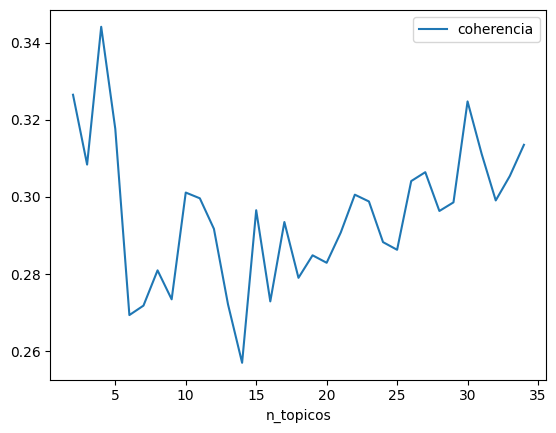

In [23]:
from matplotlib import pyplot
df_2=pd.DataFrame(diccionario_prueba).drop("modelo",axis=1)
df_2.index=df_2.n_topicos
df_2=df_2.drop("n_topicos",axis=1)
df_2.plot()
pyplot.show()

El tópico con mayor coherencia el 6 tópicos

In [24]:
mejor_modelo=diccionario_prueba[4]["modelo"]

In [25]:
for idx, topic in mejor_modelo.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.007*"emission" + 0.006*"design" + 0.006*"image" + 0.005*"model" + 0.005*"system" + 0.005*"study" + 0.005*"process" + 0.004*"software" + 0.004*"feature" + 0.004*"information"
Topic: 1 Word: 0.005*"image" + 0.005*"model" + 0.005*"time" + 0.005*"datum" + 0.005*"network" + 0.005*"problem" + 0.004*"engineering" + 0.004*"cluster" + 0.004*"risk" + 0.004*"algorithm"
Topic: 2 Word: 0.010*"image" + 0.007*"cluster" + 0.006*"fault" + 0.006*"software" + 0.005*"network" + 0.005*"system" + 0.005*"base" + 0.005*"feature" + 0.005*"design" + 0.004*"performance"
Topic: 3 Word: 0.010*"network" + 0.008*"agent" + 0.006*"model" + 0.005*"immune" + 0.005*"problem" + 0.005*"system" + 0.005*"information" + 0.004*"environment" + 0.004*"fuzzy" + 0.004*"process"
Topic: 4 Word: 0.005*"process" + 0.005*"model" + 0.005*"network" + 0.005*"image" + 0.005*"method" + 0.005*"system" + 0.005*"production" + 0.004*"equilibrium" + 0.004*"knowledge" + 0.004*"ethanol"
Topic: 5 Word: 0.007*"cluster" + 0.005*"netw

In [27]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(mejor_modelo, corpus_tfidf, dictionary)
pyLDAvis.save_json(vis, 'lda_data.json');
vis

/home/nivalderramas/dev/horus/lda/venv/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/nivalderramas/dev/horus/lda/venv/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/nivalderramas/dev/horus/lda/venv/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/nivalderramas/dev/horus/lda/venv/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in fa

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.024181 -0.016391       1        1  24.383400
4     -0.019786 -0.008389       2        1  19.242065
5      0.002590  0.012682       3        1  17.749740
0     -0.015323 -0.019535       4        1  13.890647
3     -0.009966  0.024083       5        1  13.851765
1      0.018304  0.007550       6        1  10.882383, topic_info=            Term      Freq      Total Category  logprob  loglift
332        agent  8.000000   8.000000  Default  30.0000  30.0000
740       immune  6.000000   6.000000  Default  29.0000  29.0000
325     glycerol  5.000000   5.000000  Default  28.0000  28.0000
318     catalyst  7.000000   7.000000  Default  27.0000  27.0000
690        fault  8.000000   8.000000  Default  26.0000  26.0000
..           ...       ...        ...      ...      ...      ...
182  information  1.414933  12.590233   Topic6  -5.6863   0.0322
425     approach  1.422760  12.896540   Topic6  -5.6808   0.0137
71          base  1.418187  14.229095   Topic6  -5.6840  -0.0879
217  application  1.354290  10.718428   Topic6  -5.7301   0.1493
211    technique  1.357210  11.912416   Topic6  -5.7280   0.0459

[376 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         1  0.360939  able
0         2  0.180470  able
0         3  0.180470  able
0         5  0.180470  able
0         6  0.180470  able
...     ...       ...   ...
66        2  0.186322  work
66        3  0.186322  work
66        4  0.186322  work
66        5  0.093161  work
66        6  0.093161  work

[1096 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 6, 1, 4, 2])

In [ ]:
datos=pd.concat([pd.DataFrame(b),pd.DataFrame(c)],axis=1)
datos.columns=["Topicos","Coherencia"]

In [ ]:
print(datos)

     Topicos  Coherencia
0   0.315194           2
1   0.298580           3
2   0.264084           4
3   0.290152           5
4   0.327918           6
5   0.280211           7
6   0.306043           8
7   0.299931           9
8   0.261314          10
9   0.283617          11
10  0.273572          12
11  0.263968          13
12  0.280764          14
13  0.283218          15
14  0.296128          16
15  0.291480          17
16  0.287937          18
17  0.293303          19
18  0.293663          20
19  0.307629          21
20  0.305776          22
21  0.294096          23
22  0.304615          24
23  0.301519          25
24  0.305548          26
25  0.311014          27
26  0.298096          28
27  0.318830          29
28  0.317201          30
29  0.291680          31
30  0.304217          32
31  0.315980          33
32  0.317689          34


In [ ]:
b

[0.2570165844639618,
 0.2735871080472022,
 0.27242459115764717,
 0.30063781897051844,
 0.285767938190353,
 0.2840918367806811,
 0.30347139279544805,
 0.29527041552484784,
 0.29257377615052327,
 0.3198583079486294,
 0.3146333007955101]

In [ ]:
# Create document word matrix
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words=stopwords,             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)
print(data_vectorized.shape)

(742, 949)


/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['activated', 'cytokine', 'diet', 'induced', 'line', 'lisis', 'perzonalized', 'realiz', 'spin', 'strategies'] not in stop_words.
  warnings.warn(


In [ ]:
#SPARSE DATA
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  4.147080626791146 %


In [ ]:
#GRID SEARCH TO FIND BEST n_components
#TARDA 11 min maomenos
# Define Search Param
search_params = {'n_components': [4], 
                 'learning_decay': [0.5],
                 'max_iter':[100],            # Max learning iterations
                 'evaluate_every': [20],
                 'batch_size':[128],          # n docs in each learning iter
                 'n_jobs':[-1],               # Use all available CPUs
                 }

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(estimator=lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'batch_size': [128], 'evaluate_every': [20],
                         'learning_decay': [0.5], 'max_iter': [100],
                         'n_components': [4], 'n_jobs': [-1]})

In [ ]:
#GET BEST MODEL
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'batch_size': 128, 'evaluate_every': 20, 'learning_decay': 0.5, 'max_iter': 100, 'n_components': 4, 'n_jobs': -1}
Best Log Likelihood Score:  -62358.776883622995
Model Perplexity:  541.551637560048
